In [1]:
#Import nescesary packages

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from collections import Counter
import statistics
import scipy. stats as stats
import seaborn as sns

#Import sklearn packages
import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, datasets

In [2]:
#import the vehicle dataset from Kaggle
raw_data = pd.read_csv('vehicles.csv')

# Task 1 Identify Features

1. Assemble a dataset consisting of features and target (for example in a dataframe or in two
   arrays X and y). 
2. What features are relevant for the prediction task?
3. Are there any features that should be excluded because they leak the target information?
4. Show visualizations or statistics to support your selection.
5. You are not required to use the description column, but you can try to come up with relevant
   features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later
   in the class.

1.1 

In [3]:
#Drop rows that have a selling price of $0, as that is not useful in price prediction
raw_data = raw_data[raw_data.price != 0]

In [4]:
#Subsample of the data
reduced_data = raw_data.sample(frac=(1/10), random_state=0, axis=0)

In [5]:
# 1.1
target = reduced_data['price'] #y
features = reduced_data.drop(columns=['price']) #X

1.2, 1.3 

The features that are relevent to car selling price are 'value adding' features. This can be things such as make and model, number of cyllindars, the odeometer reading, and the year amung many other. Other features that are important to a buyer, such as the vin number, are unique to the car itself. they can be leveraged to gain more information such as the accident history, but by themselves they do not add or remove any value to the car. Therefore, we deciced to drop these values in this setting. 
The description column includes the price for some listings, so it was removed.

In [6]:
#1.2, 1.3, 1.5
#Drop county because entire column is NaN
#drop datapoints that are duplicate information
#This informaiton is unique to every single car, and therefore is not a predictive feature
# This column leaks the price (e.g. 2019 Jeep Cherokee Latitude Plus -- $24,895) so it is also dropped
features = features.drop(columns=['url','region_url', 'image_url','county','vin','id','description']) #url information also shown in a text column


In [7]:
features

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
487623,dallas / fort worth,2012.0,NaN,freightliner cascadia,excellent,8 cylinders,diesel,675000.0,clean,manual,4wd,full-size,truck,orange,tx,26.3446,-80.2109
390893,akron / canton,2003.0,ram,1500,excellent,8 cylinders,gas,86332.0,clean,automatic,4wd,full-size,pickup,grey,oh,41.1790,-81.2464
24431,olympic peninsula,2017.0,ram,1500,NaN,8 cylinders,gas,41559.0,clean,automatic,4wd,NaN,truck,white,wa,47.1991,-122.3150
345946,lincoln,2017.0,toyota,tundra 4wd 4x4 sr5 4dr cr,NaN,NaN,gas,104708.0,clean,automatic,NaN,NaN,NaN,NaN,ne,41.1303,-96.2532
363858,albany,1966.0,NaN,Plymouth Barracuda,excellent,6 cylinders,gas,120000.0,clean,manual,rwd,NaN,NaN,blue,ny,42.1974,-73.5097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177619,sarasota-bradenton,2018.0,NaN,Porsche MACAN,NaN,NaN,other,10763.0,clean,automatic,NaN,NaN,NaN,NaN,fl,27.2866,-82.4770
422931,eugene,2006.0,volvo,xc90,excellent,NaN,gas,0.0,clean,automatic,4wd,NaN,SUV,silver,or,45.3754,-122.6020
151890,"washington, DC",2006.0,pontiac,gto,NaN,NaN,gas,31505.0,clean,manual,NaN,compact,coupe,silver,dc,38.5094,-77.3709
357751,south jersey,2012.0,chrysler,300,NaN,NaN,gas,83787.0,clean,automatic,rwd,full-size,sedan,black,nj,40.1815,-74.6633


In [8]:
#sort variables into continuous and categorical
continuous = []
categorical = []
for column in features.columns:
    if features[column].dtype == 'float':
        continuous.append(column)
    else:
        categorical.append(column)

In [9]:
#replace Nan values with wither median (continuous) or most frequent (categorical)
continuous_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [10]:
features[continuous]= continuous_imputer.fit_transform(features[continuous])
features[categorical] = categorical_imputer.fit_transform(features[categorical])

In [44]:
for cat in categorical:
    if len(features[cat].value_counts()) < 20:
        print(f'{cat}: {len(features[cat].value_counts())}')
    else:

region: 400
manufacturer: 40
model: 8949
condition: 6
cylinders: 8
fuel: 5
title_status: 6
transmission: 3
drive: 3
size: 4
type: 13
paint_color: 12
state: 51


In [51]:
i=0
for cat in categorical:
    if len(features[cat].value_counts()) < 20:
        print(cat)

condition
cylinders
fuel
title_status
transmission
drive
size
type
paint_color


In [12]:
features.isnull().sum()

region          0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
lat             0
long            0
dtype: int64

In [49]:
def box(category, num=None):
    sns.set(style='whitegrid')
    ax = sns.boxplot(x=features[str(category)],y=target, showfliers = False, ax=axes[num])
    ax.set_title(f'{category} vs price')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

In [14]:
def stripplot(category):
    ax = sns.stripplot(x= features[category], y=target)
    ax.set_ylim(0, 400000)
    ax.set_xticklabels(features[category],rotation=90)
    ax.set_title(f'{category} vs price')

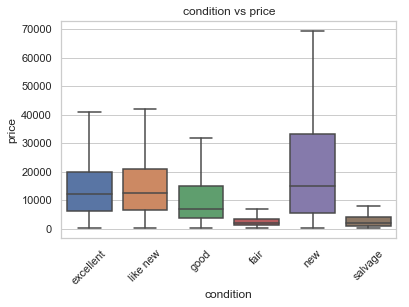

In [33]:
box('condition')

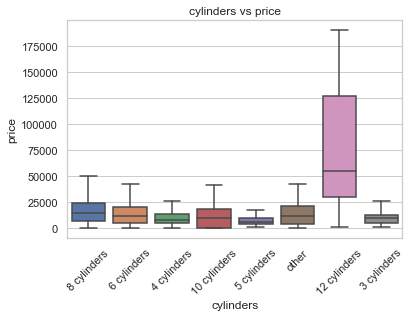

In [34]:
box('cylinders')

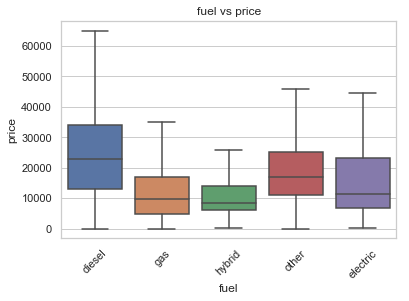

In [35]:
box('fuel')

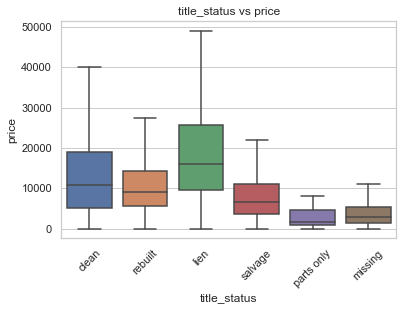

In [36]:
box('title_status')

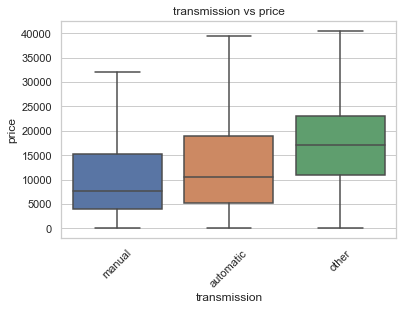

In [37]:
box('transmission')

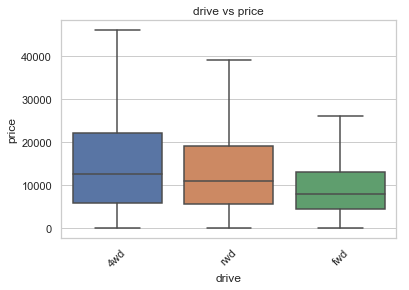

In [38]:
box('drive')

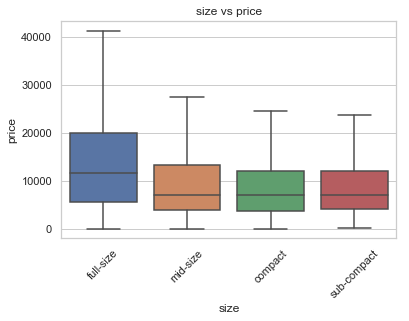

In [40]:
box('size')

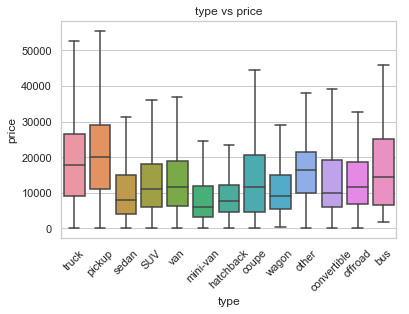

In [41]:
box('type')

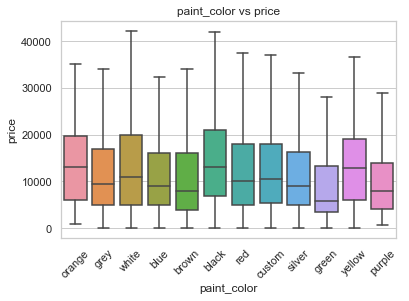

In [42]:
box('paint_color')

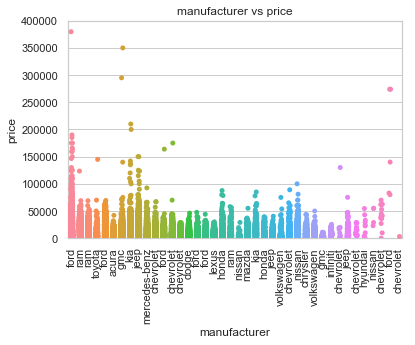

In [56]:
stripplot('manufacturer')

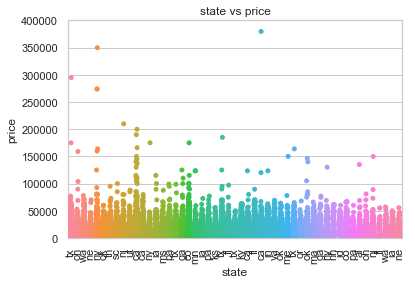

In [55]:
stripplot('state')

Text(0.5, 1.0, 'state vs price')

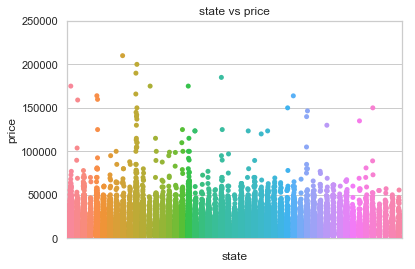

In [64]:
ax = sns.stripplot(x= features['state'], y=target)
ax.set_ylim(0, 250000)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'state vs price')

Text(0.5, 1.0, 'region vs price')

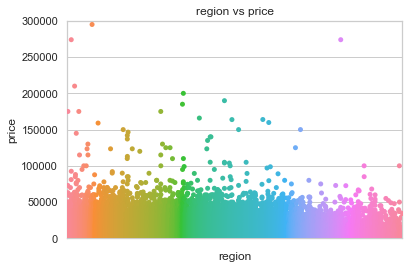

In [66]:
ax = sns.stripplot(x= features['region'], y=target)
ax.set_ylim(0, 300000)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'region vs price')

Text(0.5, 1.0, 'model vs price')

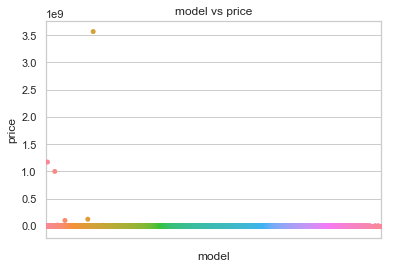

In [68]:
ax = sns.stripplot(x= features['model'], y=target)
ax.set_xticklabels([],rotation=90)
ax.set_title(f'model vs price')

# Task 2: Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing
appropriate preprocessing and cross-validating a linear model. Feel free to exclude features or
do simplified preprocessing for this task. As mentioned before, you don’t need to validate the
model on the whole dataset.

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(features, target, shuffle=True)

In [ ]:
def most_frequent(column):
    array = np.asarray(reduced_data[column])
    counter = Counter(array)
    return counter.most_common

In [ ]:
most_frequent('cylinders')
# cat = [x for x in some_list if x in some_other_list]
# cat = [col for col in categorical if col in nan_list]
# con = [col for col in continuous if col in nan_list]

In [ ]:
#scaling
columntransformer=ColumnTransformer([('encoder', OneHotEncoder(), categorical),
                                     ('standardscalar', StandardScaler(), continuous)], remainder='passthrough')

In [ ]:
#Pre-Processing 
log_pipeline = make_pipeline(imputer, columntransformer, LogisticRegression())
lin_pipeline = make_pipeline(imputer, columntransformer,sklearn.svm.LinearSVC())
neighbor_pipeline = make_pipeline(imputer, columntransformer, neighbors.KNeighborsClassifier())

In [ ]:
#gridsearch 
log_scores= cross_val_score(log_pipeline,X_trainval,y_trainval, cv=10)
print(f'mean score is {log_scores.mean()}, the std is {log_scores.std()}')

# Task 2: Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing
appropriate preprocessing and cross-validating a linear model. Feel free to exclude features or
do simplified preprocessing for this task. As mentioned before, you don’t need to validate the
model on the whole dataset.

# Airing of the Greivances 

        1. can we train test split at the v ery beginning because we have to impute at the beginning to remove NaN and dont want to add bias
    Task 1
    1. it says to show images and decisions for features that we dropped, but we did these based on logic. what do we show? Can we jsut show NaN or uniqueness 
    2. For the data that we did keep, do we jsut show the pearson correlation values for continuous and chi squared for categorical
    3. what happens if all of those vales are bad?
    Task 2
    1. whatever we initially decide is important- we go forward and do an initial score on these?

# Responses 

1a. artificially creating a cross val set so that you can. Impute and do pre-processing and THEN do train test split. As long as the test data is not specefied, we can impute with median. also be ok to replace test data with training median. 
Task1 
1. the scatter plots are good for this, just clean them up. There is not a good way to do this for categorical, just do histagrams to show how the classes are distributed over the prediction. categories relate to predictions. 
2. correlation is good for the continuous, show min&max to show that they make sense; fo rcategorical chai squared is good. Look at things from slides. Show distribution of categories in a class. 
3. this is not conclusive. this is a naiive way to think aobut things. Multi-colinearity could show these relationships. Include variables that showed good promise in the visualizations. 
Task 2
1. do this based off whatever you chose from task 1. I am in a hurry to create a model, you need results quickly and just want the minimum viable model to dump into Sci-Kit learn (in the right format with matricies) e.g. encode the features and scale, etc. 